# First Stage
## Unsupervised Anomaly Detection


To the unsupervised anomaly detection we employed 3 different Deep Neural Networks (DNN) - Model 1: LSTM Autoencoder (M1), Model 2: CNN-LSTM (M2) and Model 3: CNN-BiLSTM (M3).
The configurations of their architectures are explained as follows. In M1 we used 2 encoder layers and two decoder layers, each with 1024 and 512 LSTM units respectively. The M2 is composed by 2 CNN layers of 1024 and 512 layers respectively and 4 stacked layers of 512 LSTM units. To the M3 we opted for 2 CNN layers of 1024 and 512 units, and 4 stacked layers of BiLSTM units.

In this stage of the approach each model takes as input, sequences of 20 messages and 6 features (X and Y of position and speed vectors, the send time and sender pseudo ID).
The idea in this stage is to detect anomalies, by reconstructing the sequences passed as input and checking if the reconstruction error is superior to a threshold. To do so, each model was only trained in genuine sequences to learn the representation of a genuine behavior. So, when the model is passed a sequence, it will reconstruct that sequence producing a sequence whose pattern and values should be identical to the genuine data sequence. We then calculate the reconstruction error and pass this values to the thresholding algorithm. To calculate the reconstruction error we used the mean squared error between the the reconstructed sequence and the original sequence.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler


Loading the Genuine data (it is important to guarantee that the data is only composed by genuine samples)


In [2]:
genuine_data_path = "C:\\Users\\tcosta\\Desktop\\VeReMi-Dataset\\genuine_nosort_mp_3500_pseudo.csv"
train_data= pd.read_csv(genuine_data_path,  encoding='utf8', sep=',', header=0)
train_data.drop(['attack'], axis=1, inplace=True)

In [3]:
train_data

,sendTime,posX,posY,spdX,spdY,senderPseudo
0,28535.013764,181.519945,891.698383,-4.538430,-0.600631,1097832.0
1,28535.169082,145.372169,891.524489,-1.106934,-2.789263,10101612.0
2,28535.208921,152.391028,909.001472,1.123800,-15.154916,10102092.0
3,28535.221525,170.028482,889.764678,-1.306324,-0.172629,1097292.0
4,28535.611519,162.029408,889.237818,0.000452,0.000452,1096872.0
...,...,...,...,...,...,...
1329995,27112.535069,188.826721,539.779185,0.000240,0.000240,1052232.0
1329996,27112.959575,383.150803,515.363692,-6.355285,-5.273393,1053372.0
1329997,27113.535069,188.606217,539.809818,0.000240,0.000240,1052232.0
1329998,27113.959575,376.568343,512.248939,-7.791961,-2.735168,1053372.0


Since the models developed are expecting the data in the formt of sequences, here we transform the data into sequences of 20 messages and apply a Standard Scaler to the data.

In [3]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(train_data.values)

sequence_length = 20

X_train = []

for i in range(0, len(normalized_data) ,20):
    X_train.append(normalized_data[i:i + sequence_length, :])


X_train = np.array(X_train)

In [5]:
X_train.shape

(66500, 20, 6)

### Model M1: LSTM Autoencoder definition

In [ ]:
import keras
model = keras.Sequential()

# Encoder
model.add(keras.layers.LSTM(1024, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dropout(rate=0.2))


# Bottleneck (RepeatVector)
model.add(keras.layers.RepeatVector(X_train.shape[1]))

# Decoder
model.add(keras.layers.LSTM(units=512, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=1024, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

# TimeDistributed Dense layer for output
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=4)))


model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, X_train[:,:,1:5], epochs=100,batch_size=20, validation_split=0.2)

# Plot training loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss of LSTM Autoencoder')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


### Model M2: CNN-LSTM definition

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten, Reshape, Dropout

model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=1024, kernel_size=3, activation='relu', input_shape=(20, 6)))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))


# LSTM layer
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=512, return_sequences=True))

# Flatten the output before the dense layer
model.add(Flatten())

# Dense layer for reconstruction
model.add(Dense(units=20 * 4))  # Adjusted output shape

# Reshape the output to (20, 4)
model.add(Reshape((20, 4)))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

# Display the model summary
model.summary()
# Train the model
history = model.fit(X_train, X_train[:,:,1:5], epochs=50, batch_size=20, validation_split=0.2)

# Plot training loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss of CNN-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### Model M3: CNN-BiLSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Flatten, Reshape, Dropout

model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=1024, kernel_size=3, activation='relu', input_shape=(20, 6)))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))


# LSTM layer
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(rate=0.2))
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(rate=0.2))
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))
model.add(Dropout(rate=0.2))
model.add(Bidirectional(LSTM(units=512, return_sequences=True)))

# Flatten the output before the dense layer
model.add(Flatten())

# Dense layer for reconstruction
model.add(Dense(units=20 * 4))  # Adjusted output shape

# Reshape the output to (20, 4)
model.add(Reshape((20, 4)))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

# Display the model summary
model.summary()
# Train the model
history = model.fit(X_train, X_train[:,:,1:5], epochs=50, batch_size=20, validation_split=0.2)

# Plot training loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss of CNN-BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

Save the model trained to disk. Use formats like .h5 or .keras

In [ ]:
model_trained_name = "trained.h5"
model.save(model_trained_name)

Code for model loading (avoid training again )

In [4]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("genuine2_posspd_pseudofix_MAE_bt20_100epochs.h5")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 1024)          4222976   
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 20, 512)           0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 20, 512)           2099200   
                                                        

Reading the test dataset (the one that will be used in the supervised learning)

In [5]:
test_dataset_path = "C:\\Users\\tcosta\\Desktop\\VeReMi-Dataset\\15200seqall_pseudo.csv"
X_test_o = pd.read_csv(test_dataset_path, encoding='utf8', sep=',', header=0)

Auxiliary code to check if the test data is balanced.

In [7]:
import pandas as pd

test_smaller = []
gen_count = 0
attack_count = {i: 0 for i in range(1, 20)}  # Assuming attack types from 1 to 19

for i in range(0, len(X_test_o), 20):
    seq = X_test_o.loc[i:i + sequence_length - 1].copy()
    attack_type = seq["attack"].max()

    if attack_type == 0 and gen_count < 7600:
        gen_count += 1
        test_smaller.append(seq)
    elif attack_type != 0 and attack_count[attack_type] < 400:
        attack_count[attack_type] += 1
        test_smaller.append(seq)

    # Check if we have collected 7600 sequences of type 0 and 400 sequences for each other attack type
    if gen_count == 7600 and all(count == 400 for count in attack_count.values()):
        break

X_test_o = pd.concat(test_smaller, ignore_index=True)

In [8]:
attack_count

{1: 400,
 2: 400,
 3: 400,
 4: 400,
 5: 400,
 6: 400,
 7: 400,
 8: 400,
 9: 400,
 10: 400,
 11: 400,
 12: 400,
 13: 400,
 14: 400,
 15: 400,
 16: 400,
 17: 400,
 18: 400,
 19: 400}

Dropping the attack column (comes from VeReMi)

In [6]:
X_test = X_test_o.drop(['attack'], axis=1)
X_test

,sendTime,posX,posY,spdX,spdY,senderPseudo
0,28468.090253,1072.964438,946.771904,16.251330,4.190135,1095432.0
1,28468.106679,1028.192775,928.521196,-12.789472,-3.236370,1099032.0
2,28468.291273,1232.611616,986.054347,15.406516,0.276186,1097472.0
3,28468.295233,1086.661636,943.648126,-13.675241,-3.520100,1098792.0
4,28468.317795,1069.746416,948.589687,10.907709,2.807073,1094892.0
...,...,...,...,...,...,...
303995,25705.256333,1142.248922,957.848987,-12.610293,-3.246047,1012452.0
303996,25705.291796,1385.520456,1169.570612,3.390393,15.659926,108192.0
303997,25705.349016,1168.857385,964.862543,-13.533834,-3.483307,1012272.0
303998,25705.578136,1037.168873,934.210246,-12.806180,-3.298354,1012692.0


The test data needs to be transformed according to the training data, so the same standard scaler is used

In [7]:

normalized_data = scaler.transform(X_test.values)

sequence_length = 20

# Create sequences for training
test = []
for i in range(0, len(normalized_data), 20):
    test.append(normalized_data[i:i + sequence_length, :])

test = np.array(test)

In [8]:
# Use the trained model to reconstruct the input data
reconstructed_data = model.predict(test)

475/475 [==============================] - 179s 374ms/step


Auxiliary code to calculate the mean inference time

In [10]:
import time
def run_inference(sequence):
  start_time = time.time()
  prediction = model.predict(sequence[None, :, :])  # Add batch dimension
  inference_time = time.time() - start_time
  return prediction, inference_time


num_runs = 100
total_time = 0

for _ in range(num_runs):
  random_index = np.random.randint(0, len(test))
  sequence = test[random_index]
  prediction, inference_time = run_inference(sequence)
  total_time += inference_time

average_inference_time = total_time / num_runs


print(f"Average Inference Time per Sequence: {average_inference_time:.4f} seconds")

1/1 [==============================] - 0s 153ms/step
Average Inference Time per Sequence: 0.1015 seconds


Needed code to the thresholding algorithm, where it labels the whole window instead of the individual messages. Since we have the type of attack in this stage, we also use it to then calculate the recall of each attack.

In [9]:
y_test= np.zeros((test.shape[0], 1))
y_test_non_binary = np.zeros((test.shape[0], 1))
j = 0
for i in range(0, len(X_test_o) ,20):
    seq = X_test_o.loc[i:i + sequence_length - 1].copy()
    if (seq["attack"] == 0).all():
        y_test[j] = 0
        y_test_non_binary[j] = 0
    elif (seq["attack"] != 0).any():
        y_test[j] = 1
        y_test_non_binary[j] = seq["attack"].max()
    j+=1


y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y_test_non_binary

In [10]:
y_test_expanded = np.repeat(y_test, 20, axis=0)

In [11]:
y_test_non_binary = np.repeat(y_test_non_binary,20,axis=0)

### Thresholding algorithm


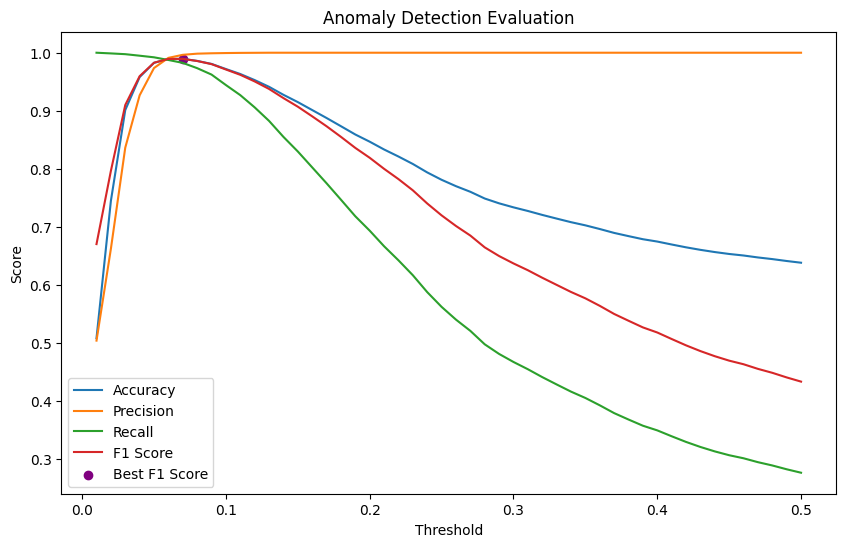

Best Threshold: 0.06999999999999999
Best Accuracy: 0.9894736842105263
Best Precision: 0.9963971176941553
Best Recall: 0.9825
Best F1 Score: 0.9893997614946337
Confusion Matrix: [[151460    540]
 [  2660 149340]]
Classification report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    152000
         1.0       1.00      0.98      0.99    152000

    accuracy                           0.99    304000
   macro avg       0.99      0.99      0.99    304000
weighted avg       0.99      0.99      0.99    304000



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, mean_absolute_error

def anomaly_detection_and_evaluation(test, reconstructed_data, X_test, X_test_o, threshold_values):
    results = []

    for threshold in threshold_values:
       
        test_flatten = test[:,:,1:5].reshape(test.shape[0] * 20, 4)
        
        mae_values = np.mean(np.abs(test[:, :, 1:5] - reconstructed_data), axis=(1,2))
        predictions = (mae_values > threshold).astype(int)
        predictions_expanded = np.repeat(predictions, 20, axis=0)

        labeled_dataset = pd.DataFrame(data=X_test.loc[:test_flatten.shape[0], :], columns=X_test.columns)
        labeled_dataset['label'] = predictions_expanded
       # print(labeled_dataset)
        # Evaluate the performance
        accuracy = accuracy_score(y_test_expanded,labeled_dataset['label'])
        precision = precision_score(y_test_expanded,labeled_dataset['label'])
        recall = recall_score(y_test_expanded,labeled_dataset['label'])
        f1 = f1_score(y_test_expanded,labeled_dataset['label'])
        matrix = confusion_matrix(y_test_expanded,labeled_dataset['label'])
        report = classification_report(y_test_expanded,labeled_dataset['label'])


        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'class_matrix': matrix,
            'report': report
        })
        #print(report)

    # Find the threshold that maximizes the F1 score
    best_result = max(results, key=lambda x: x['f1'])
    best_acc = max(results, key=lambda x: x['accuracy'])
    best_prec= max(results, key=lambda x: x['precision'])
    best_recall = max(results, key=lambda x: x['recall'])

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot([result['threshold'] for result in results], [result['accuracy'] for result in results], label='Accuracy')
    plt.plot([result['threshold'] for result in results], [result['precision'] for result in results], label='Precision')
    plt.plot([result['threshold'] for result in results], [result['recall'] for result in results], label='Recall')
    plt.plot([result['threshold'] for result in results], [result['f1'] for result in results], label='F1 Score')

    # Highlight the best values in the plot
    #plt.scatter(best_acc['threshold'], best_acc['accuracy'], c='red', marker='o', label='Best Accuracy')
    #plt.scatter(best_prec['threshold'], best_prec['precision'], c='green', marker='o', label='Best Precision')
    #plt.scatter(best_recall['threshold'], best_recall['recall'], c='blue', marker='o', label='Best Recall')
    plt.scatter(best_result['threshold'], best_result['f1'], c='purple', marker='o', label='Best F1 Score')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Anomaly Detection Evaluation')
    plt.legend()
    plt.show()

    # Print the best values
    print("Best Threshold:", best_result['threshold'])
    print("Best Accuracy:", best_result['accuracy'])
    print("Best Precision:", best_result['precision'])
    print("Best Recall:", best_result['recall'])
    print("Best F1 Score:", best_result['f1'])
    print("Confusion Matrix:", best_result['class_matrix'])
    print("Classification report:", best_result['report'])



    return best_result['threshold']

threshold_values = np.linspace(0.01, 0.5, 50)  # Adjust the range as needed
best_threshold = anomaly_detection_and_evaluation(test, reconstructed_data, X_test, X_test_o, threshold_values)

With the best threshold, label the dataset so it can be used in the second stage

In [13]:
       
test_flatten = test[:,:,1:5].reshape(test.shape[0] * 20, 4)

test_shape = test.shape[0]
mae_values = np.mean(np.abs(test[:, :, 1:5] - reconstructed_data), axis=(1, 2))
predictions = (mae_values > best_threshold).astype(int)
predictions_expanded = np.repeat(predictions, 20, axis=0)

labeled_dataset = pd.DataFrame(data=X_test.loc[:test_flatten.shape[0], :], columns=X_test.columns)
labeled_dataset['label'] = predictions_expanded

In [14]:
from sklearn.metrics import recall_score
recall_per_attack = {}
for attack_type in range(1, 20):
    true_labels = (y_test_non_binary[:, 0] == attack_type).astype(int)
    predicted_labels = predictions_expanded
    recall = recall_score(true_labels, predicted_labels)
    recall_per_attack[attack_type] = recall
# Print the recall values
for attack_type, recall in recall_per_attack.items():
    print(f'Recall for attack type {attack_type}: {recall}')

Recall for attack type 1: 0.98
Recall for attack type 2: 0.9975
Recall for attack type 3: 1.0
Recall for attack type 4: 1.0
Recall for attack type 5: 0.995
Recall for attack type 6: 0.9775
Recall for attack type 7: 1.0
Recall for attack type 8: 0.99
Recall for attack type 9: 0.9975
Recall for attack type 10: 0.9975
Recall for attack type 11: 1.0
Recall for attack type 12: 1.0
Recall for attack type 13: 0.875
Recall for attack type 14: 0.985
Recall for attack type 15: 0.92
Recall for attack type 16: 0.9525
Recall for attack type 17: 1.0
Recall for attack type 18: 1.0
Recall for attack type 19: 1.0


In [20]:
from sklearn.metrics import recall_score
true_labels = (y_test_expanded[:, 0] == 0).astype(int)
predicted_labels = (predictions_expanded[:] == 0)
recall = recall_score(true_labels, predicted_labels)
recall_genuine_attack = recall_score(true_labels, predicted_labels)

print(f'Recall for genuine attacks: {recall_genuine_attack}')

Recall for genuine attacks: 0.9942105263157894


In [58]:
labeled_dataset.to_csv('labeled_best.csv', index=False)

### Experiment

If there was not second stage, the inference service would need to be deployed with the best threshold (impractical)

In [21]:
sequence = np.array([[[ 1.89002003, -1.03167445,  0.87793484, -0.58292701, -0.11136934,
        -0.34467044],
       [ 1.89017635, -1.12578504,  0.87732129, -0.14838307, -0.37921884,
         2.4836808 ],
       [ 1.89021644, -1.10751147,  0.93898524,  0.13410349, -1.89255374,
         2.48383158],
       [ 1.89022912, -1.06159243,  0.87111216, -0.17363266, -0.05898961,
        -0.34484007],
       [ 1.89062161, -1.08241799,  0.86925325, -0.00815044, -0.03780754,
        -0.34497201],
       [ 1.8906691 , -1.14649272,  0.93389556, -0.11799506,  1.39405162,
        -0.34402962],
       [ 1.89102643, -1.04125742,  0.8762854 , -0.3736385 , -0.08446974,
        -0.34467044],
       [ 1.89118274, -1.13342241,  0.86794667, -0.45240554, -0.45733001,
         2.4836808 ],
       [ 1.89122283, -1.10120998,  0.88646053,  0.52063826, -1.83006123,
         2.48383158],
       [ 1.89123552, -1.06407928,  0.87070359, -0.0750472 , -0.04631757,
        -0.34484007],
       [ 1.89162802, -1.08248847,  0.86929427, -0.00815044, -0.03780754,
        -0.34497201],
       [ 1.89167551, -1.14927921,  0.97938058, -0.13958473,  1.67562436,
        -0.34402962],
       [ 1.89218914, -1.14704393,  0.86102075, -0.84074821, -0.2931538 ,
         2.4836808 ],
       [ 1.89224192, -1.06453112,  0.87059766, -0.03235033, -0.04082883,
        -0.34484007],
       [ 1.89263441, -1.08261677,  0.8692436 , -0.00815044, -0.03780754,
        -0.34497201],
       [ 1.8926819 , -1.15197266,  1.03211742, -0.15023391,  1.81451622,
        -0.34402962],
       [ 1.89319553, -1.16787928,  0.85796262, -1.13196865, -0.11953203,
         2.4836808 ],
       [ 1.89364081, -1.08275852,  0.86924715, -0.00815044, -0.03780754,
        -0.34497201],
       [ 1.8936883 , -1.15482304,  1.08562297, -0.15133162,  1.82883197,
        -0.34402962],
       [ 1.89420193, -1.18705345,  0.85652165, -0.70584472, -0.07647499,
         2.4836808 ]]])

In [22]:
sequence.shape

(1, 20, 6)

In [23]:
sequence_reconstruted = model.predict(sequence)
best_threshold = 0.06999999999999999

mae_values = np.mean(np.abs(sequence[:,:,1:5] - sequence_reconstruted), axis=(1, 2))
predictions = (mae_values > best_threshold).astype(int)

1/1 [==============================] - 2s 2s/step


# Second Stage
## Supervised learning

This stage is the one that is deployed and the one that detects the misbehaviors in the proposed V2X scenario. To this task we employed 2 different DNN : Model 1: CNN (S1) and Model 2: Stacked LSTM (S2).
We convert our input sequence of 20 x 6 into an image and then we pass it to the S1 model. The S1 is composed by 2 2D CNN layers of 256 and 128 units respectively, being followed by 2 dense layers of 100 and 10 units. The output is also a dense layer, however with just one unit and activated by the sigmoid function since we want to classify the sequence as attack or genuine.

The S2 model is a 4 stacked LSTM and it is composed by 4 layers of 256 LSTM units. The output layer is also a dense layer with just one unit activated by the sigmoid function. 

Read the labeled dataset from the previous stage and the original one (just to testing phase)

In [59]:
original_dataset = pd.read_csv("15200seqall_pseudo.csv", encoding='utf8', sep=',',header=0)
labeled_dataset = pd.read_csv("labeled_best.csv", encoding='utf8', sep=',', header=0)

In [60]:
test_data_o = original_dataset
X_te = test_data_o.drop(['attack'], axis=1)
y_te = test_data_o['attack']

In [61]:
train_data_o = labeled_dataset
X_train = train_data_o.drop(['label'], axis=1)
y_train = train_data_o['label']

In [62]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(X_train.values)

# Set your sequence length
sequence_length = 20

# Create sequences for training
X_train = []
for i in range(0, len(normalized_data), 20):
    X_train.append(normalized_data[i:i + sequence_length, :])


X_train = np.array(X_train)

In [63]:

normalized_data_test = scaler.transform(X_te.values)

sequence_length = 20

# Create sequences for training
test = []
for i in range(0, len(normalized_data_test), 20):
    test.append(normalized_data_test[i:i + sequence_length, :])

test = np.array(test)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [64]:
y_train = np.zeros((X_train.shape[0], 1))
j = 0
for i in range(0, len(train_data_o['label']) ,20):
    seq = labeled_dataset.loc[i:i + sequence_length - 1].copy()
    if (seq["label"] == 0).all():
        y_train[j] = 0
    elif (seq["label"] != 0).any():
        y_train[j] = 1
    j+=1


y_train

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [95]:
y_test_true= np.zeros((test.shape[0], 1))
j = 0
for i in range(0, len(test_data_o['attack']) ,20):
    seq = original_dataset.loc[i:i + sequence_length - 1].copy()
    if (seq["attack"] == 0).all():
        y_test_true[j] = 0
    elif (seq["attack"] != 0).any():
        y_test_true[j] = 1
    j+=1


y_test_true

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=4, stratify=y_train)

In [96]:
from sklearn.model_selection import train_test_split
_, X_test_true, _, y_test_true = train_test_split(test, y_test_true, test_size=0.3, random_state=200, stratify=y_test_true)

In [68]:
X_train_reshaped = X_train.reshape(-1, 20, 6, 1)

In [ ]:
X_train_reshaped.shape

Model S1: CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

binary_cnn_model = Sequential()

# Add the first convolutional layer with 100 filters, a (3, 3) filter size, and (1, 1) strides
binary_cnn_model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu', input_shape=(X_train_reshaped.shape[1],X_train_reshaped.shape[2],1)))

binary_cnn_model.add(Dropout(0.25))

# Add the second convolutional layer with 50 filters, a (3, 3) filter size, and (1, 1) strides
binary_cnn_model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))

# Add a 0.25 dropout layer
binary_cnn_model.add(Dropout(0.25))

# Flatten the data before sending it to fully connected layers
binary_cnn_model.add(Flatten())


binary_cnn_model.add(Dense(100, activation='relu'))
binary_cnn_model.add(Dense(10, activation='relu'))


# Add the output layer with a single neuron and sigmoid activation for binary classification
binary_cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model using binary cross-entropy as the loss function
binary_cnn_model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy', tf.keras.metrics.Recall(thresholds=0.5),tf.keras.metrics.F1Score(threshold=0.5),tf.keras.metrics.Precision()])

# Display the model summary
binary_cnn_model.summary()

Model S2: 4 Stacked LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from keras.losses import binary_crossentropy

# Define the 4-LSTM model (Model 3)
model_3 = Sequential()

# Add the first LSTM layer
model_3.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
# Add three more stacked LSTM layers
model_3.add(LSTM(256, return_sequences=True))
model_3.add(LSTM(256, return_sequences=True))
model_3.add(LSTM(256, return_sequences=False))


# Add the output dense layer with ReLU activation
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print the model summary
model_3.summary()


In [ ]:
history = model_3.fit(X_train, y_train,
                             batch_size=20,
                             epochs=15,
                             validation_split=0.2)

In [101]:
test_reshaped = X_test_true.reshape(-1, 20, 6, 1)

In [102]:
y_pred_probs = model_3.predict(test_reshaped)

143/143 [==============================] - 1s 8ms/step


In [103]:
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

In [104]:
from sklearn.metrics import precision_score, accuracy_score,recall_score,f1_score
accuracy = accuracy_score(y_pred,y_test_true)
print(accuracy)
print(precision_score(y_pred,y_test_true))
print(recall_score(y_pred,y_test_true))
print(f1_score(y_pred,y_test_true))

0.9890350877192983
0.9906583629893239
0.987145390070922
0.988898756660746
